In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/M202A Embedded Systems Project/Data_csv'

/content/drive/Shareddrives/M202A Embedded Systems Project/Data_csv


In [4]:
import numpy as np
import pandas as pd
from os import listdir
import os.path
import zipfile
from keras.utils.np_utils import to_categorical
import json
from sklearn.model_selection import train_test_split

In [5]:
def get_header():
    header = ["acc_x", "acc_y","acc_z", "gyro_x", "gyro_y","gyro_z", "activityID"]
    return header

def addheader(datasets):
    """
    The columns of the pandas data frame are numbers
    this function adds the column labels
    Parameters
    ----------
    datasets : list
        List of pandas dataframes
    """
    header = get_header()
    for i in range(0, len(datasets)):
        datasets[i].columns = header
    return datasets

In [6]:
def clip_data(ds):
  '''
  Takes in a data set and slices it to the first activityID and last activityID
  Inputs:
    - ds: a pandas dataset
  Returns:
    - ds: sliced pandas dataset, starting at the first nonzero activity ID and ending at the last nonzero activityID
  '''
  return ds[ds[ds.activityID != 0].first_valid_index():ds[ds.activityID != 0].last_valid_index()+1]

In [7]:
def label_move(ds):
  '''
  Takes a data set in the form of [1, 0, ..., 2, 2, ... 0, 0,... n] and classifies the difference between key presses
  '''
  classifier_dict = {
      1  : 1,
      2  : 2,
      3  : 3,
      4  : 4,
      -1 : -1,
      -2 : -2,
      -3 : -3,
      -4 : -4
  }
  # Shorten the presses array to remove consecutive duplicates. [1, 2, 2, 2, 3, 3, 3, 2,...] -> [1, 2, 3, 2...]
  presses = [val for val in ds if val != 0] # remove 0's
  presses_short = []
  lru_val = None
  for i in range(len(presses)):
    if i == 0:
      presses_short.append(presses[i])
      lru_val = presses[i]
    else:
      if presses[i] != lru_val:
        presses_short.append(presses[i])
        lru_val = presses[i]
  # Create an array of the differences from the shortened presses list. [1, 2, 3, 2...] -> [1, 1, -1...]
  diffs = []
  for i in range(len(presses_short)):
    try:
      diffs.append(presses_short[i+1] - presses_short[i])
    except IndexError:
      pass
  # Use the classifier dictionary to change negative movement to positive values
  motions = [classifier_dict[val] for val in diffs]
  # Go back and update ds with the motions
  motions_idx = -1
  new_ds = []
  lru_val = None
  for val in ds:
    if lru_val == None:
      new_ds.append(0)
    else:
      if val == lru_val:
        if val == 0:
          new_ds.append(motions[motions_idx])
        else:
          new_ds.append(0)
      else:
        if val == 0:
          motions_idx += 1
          new_ds.append(motions[motions_idx])
        else:
          new_ds.append(0)
    lru_val = val
  return new_ds

In [8]:
def sliding_window(frame_length, step, Xsampleslist, ysampleslist):
    """
    Splits time series in ysampleslist and Xsampleslist
    into segments by applying a sliding overlapping window
    of size equal to frame_length with steps equal to step
    it does this for all the samples and appends all the output together.
    So, the participant distinction is not kept
    Parameters
    ----------
    frame_length : int
        Length of sliding window
    step : int
        Stepsize between windows
    Xsamples : list
        Existing list of window fragments
    ysamples : list
        Existing list of window fragments
    Xsampleslist : list
        Samples to take sliding windows from
    ysampleslist
        Samples to take sliding windows from
    """
    Xsamples = []
    ysamples = []
    for j in range(len(Xsampleslist)):
        X = Xsampleslist[j]
        y = ysampleslist[j]
        for i in range(0, X.shape[0] - frame_length, step):
            xsub = X[i:i + frame_length, :]
            ysub = 0
            for z in range(i,i + frame_length + 1, 1):
              if y[z] == 1:
                ysub = 1
              elif y[z] == 2:
                ysub = 2
              elif y[z] == 3:
                ysub = 3
              elif y[z] == 4:
                ysub = 4
              elif y[z] == 5:
                ysub = 5
            # ysub = y
            Xsamples.append(xsub)
            ysamples.append(ysub)
    return Xsamples, ysamples

In [9]:
columns_to_use = ["acc_x", "acc_y","acc_z", "gyro_x", "gyro_y","gyro_z"]

datadir = os.path.join('/content/drive/Shareddrives/M202A Embedded Systems Project/Data_csv');
filenames = os.listdir(datadir)
filenames.sort()
datasets = [pd.read_csv(os.path.join(datadir, fn), header=None, sep=',')
            for fn in filenames]
#print(datasets)
datasets = addheader(datasets)
datasets_filled = [d.interpolate() for d in datasets]
datasets_clipped = [clip_data(ds) for ds in datasets_filled]

# Create input (x) and output (y) sets
xall = [np.array(data[columns_to_use]) for data in datasets_clipped]
yall = [np.array(data.activityID) for data in datasets_clipped]


In [10]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(xall, yall, test_size=0.20, random_state=9)

In [11]:
# window with 40 samples, each sample has 6 sensor data (acc x,y,z & gyro x,y,z) Thus, total of 240 sensor data in each window
x_tr, y_tr = sliding_window(40,1,X_train,y_train)
x_te, y_te = sliding_window(40,1,X_test,y_test)

motions_y_tr = label_move(y_tr)
motions_y_te = label_move(y_te)


In [12]:
print(y_te)
print(motions_y_te)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [13]:
# x_tr_temp = []
# x_te_temp = []

# for i in range(0,len(x_tr),1):
#   x_tr_sub = np.concatenate(x_tr[i])
#   x_tr_temp.append(x_tr_sub)

# for i in range(0,len(x_te),1):
#   x_te_sub = np.concatenate(x_te[i])
#   x_te_temp.append(x_te_sub)

x_tr = np.reshape(x_tr, (-1,240))
x_te = np.reshape(x_te, (-1,240))
y_tr = motions_y_tr
y_te = motions_y_te
# y_tr = np.reshape(motions_y_tr, (-1,1))
# y_te = np.reshape(motions_y_te, (-1,1))

In [ ]:
# X_train1 = np.array(X_train)
display(x_te.shape)
# display(y_te.shape)
display(len(y_te))
# display(y_te)

In [15]:
# Import different types of classifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

# model = BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0)
# model = KNeighborsClassifier()
# model = GaussianNB()
model = RandomForestClassifier()
# model = DecisionTreeClassifier()
# model = LogisticRegression()
# model = LinearSVC()

model.fit(x_tr, y_tr)

RandomForestClassifier()

[ 0  1  1 ... -2 -2 -2]


array([[ 178,    9,    0,    0,    8,    0,    0,    0],
       [   0,   86,    4,    0,    4,    0,    0,    0],
       [   0,    0,  730,   71,   15,    0,    0,    0],
       [   0,    0,    0,  479,    8,    0,    0,    0],
       [   4,    1,   10,    6, 2375,    4,    9,    1],
       [   0,    0,    0,    0,    1,  327,    0,    0],
       [   0,    0,    0,    0,   26,    7, 1145,    0],
       [   0,    0,    0,    0,    0,    0,    0,   81]])

Accuracy = 0.96636


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


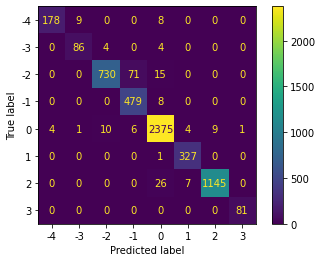

In [16]:
predictions = model.predict(x_te)
print(predictions)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_te, predictions)
display(cm)

accuracy = accuracy_score(y_te, predictions)
# precision = precision_score(y_te, predictions)
# recall = recall_score(y_te, predictions)
print('Accuracy = {:0.5f}'.format(accuracy))

plot_confusion_matrix(model, x_te, y_te)  
plt.show()
# print('Accuracy = {:0.5f}, Precision = {:0.5f}, Recall = {:0.5f}'.format(accuracy,precision,recall))

In [32]:
z = 0
while(z < len(predictions)/5):
  print(predictions[z], y_te[z])
  z = z + 1

0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
-1 0
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
0 -1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [17]:
# _, win_len, dim = x_tr.shape
# num_classes = 1

# display(win_len,dim)

In [18]:
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
# from tensorflow.keras.layers import BatchNormalization, Permute, Reshape
# from tensorflow.keras.models import Sequential

# def model_LSTM(dim, win_len, num_classes, num_hidden_lstm=32, p=0.3, batchnorm=True, dropout=True):
#     model = Sequential(name='LSTM')
#     model.add(LSTM(num_hidden_lstm,
#                    input_shape=(win_len, dim),
#                    return_sequences=True, name='Lstm_1'))
#     if batchnorm:
#         model.add(BatchNormalization(name='Bn_1'))
#     if dropout:
#         model.add(Dropout(p, name='Drop_1'))
#     model.add(LSTM(num_hidden_lstm, return_sequences=False, name='Lstm_2'))
#     if batchnorm:
#         model.add(BatchNormalization(name='Bn_2'))
#     if dropout:
#         model.add(Dropout(p, name='Drop_2'))
#     model.add(Dense(num_classes, activation='softmax', name='dense_out'))
#     return model

In [19]:
# model = model_LSTM(dim, win_len, num_classes, num_hidden_lstm=32, p=0.3)

# print(model.summary())

In [20]:
# from collections import Counter
# import sys
# import time
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
# from tensorflow.keras.models import load_model

# network_type = 'LSTM'

# print('model training ...')
# epochs = 10
# model.compile(loss=tf.keras.losses.categorical_crossentropy,
#               optimizer='adam',
#               metrics=['accuracy'])

# model_dir = f'Models'

# import os
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# name = '{}_{}'.format(network_type, int(time.time()))
# tensorboard = TensorBoard(log_dir = 'logs\{}'.format(name))

# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# # checkpoint
# filepath= f"best_{name}.hdf5"
# chk_path = os.path.join(model_dir, filepath)
# checkpoint = ModelCheckpoint(chk_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# model.fit(x_tr, y_tr,
#           batch_size=30,
#           epochs=epochs,
#           verbose=1,
#           shuffle=True,
#           callbacks=[tensorboard, checkpoint])

# model.save(os.path.join(model_dir,f'final_{name}.hdf5'))